<a href="https://colab.research.google.com/github/tfiroze/Thermal-Image-Object-Detection/blob/main/thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thermal Image Object Detection with YOLOv8

This notebook demonstrates the implementation of the YOLOv8 model for object detection in thermal images. The primary objective is to evaluate the model's performance before and after training with a custom dataset. The initial sections detail the process of converting annotations to the YOLO format and subsequently training the YOLOv8n model. The performance of the pre-trained model is then compared against the fine-tuned model, highlighting the impact of training on object detection accuracy in thermal images.

The model was trained using the TPU v2-8 on Google Colab


## Important: Using the pre-trained model
Training the YOLOv8 model can be time-consuming. To save time, the model I trained is available in the repository. You can load and utilize this model after the imports instead of training a new one.

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
model_t = YOLO('/content/runs/detect/train2/weights/best.pt')

# Imports


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install ultralytics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import json
import os
from PIL import Image
from IPython.display import display
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# NOTE The below two sections can only be run using a TPU.

# Creating labels for YOLO format using COCO files for training and validation

This section of the code converts labels from the COCO format into the YOLO format. This is a necessary step as the YOLOv8 model requires annotations to be in its specific format for training. The code iterates through each annotation in the COCO JSON file, extracts the bounding box information, and transforms it into the YOLO format. The converted labels are then saved as text files, where each text file corresponds to an image and contains the object class and bounding box coordinates.

In [ ]:
coco_json_path = '/content/drive/MyDrive/Thermal/coco_train.json'  # COCO JSON file
images_dir = '/content/drive/MyDrive/Thermal/images/train'  # Directory where the images are stored
labels_dir = '/content/drive/MyDrive/Thermal/labels/train'  # Directory where the YOLO-format labels will be stored



# Create labels directory if it doesn't exist
os.makedirs(labels_dir, exist_ok=True)

# Load the COCO annotations JSON file
with open(coco_json_path) as f:
    coco_data = json.load(f)

# Helper function to convert COCO bbox format to YOLO format
def convert_bbox_to_yolo(image_width, image_height, bbox):
    x_min, y_min, width, height = bbox
    center_x = x_min + width / 2
    center_y = y_min + height / 2
    return center_x / image_width, center_y / image_height, width / image_width, height / image_height

# Process each annotation in the COCO file
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)

    if image_info is None:
        print(f"Warning: No image found with id {image_id}")
        continue

    image_file = image_info['file_name']
    img_width = image_info['width']
    img_height = image_info['height']

    # Ensure any necessary subdirectories are created in the labels directory
    label_file = os.path.join(labels_dir, f"{image_file.split('.')[0]}.txt")
    os.makedirs(os.path.dirname(label_file), exist_ok=True)

    # COCO bbox format is [x_min, y_min, width, height]
    bbox = annotation['bbox']

    # Convert bbox to YOLO format
    yolo_bbox = convert_bbox_to_yolo(img_width, img_height, bbox)

    # Get class id (COCO classes usually start from 1, while YOLO expects them to start from 0)
    class_id = annotation['category_id'] - 1  # Adjust class id to start from 0

    # Write the label in YOLO format to the file
    with open(label_file, 'a') as f:
        f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

print("Conversion complete. YOLO-format labels have been saved.")


Conversion complete. YOLO-format labels have been saved.


# Training the YOLOv8n model.

## data.yaml file


The YAML file is a configuration file that provides essential information to the YOLOv8 model during training. It defines various parameters, including:

Training and validation data paths: It specifies the location of the training and validation datasets.
Number of classes: It defines the number of object categories the model needs to identify.
Names of classes: It provides a list of the names corresponding to each object class.
This configuration file plays a vital role in ensuring the model is correctly set up for the specific object detection task

In [19]:
with open('/content/drive/MyDrive/Thermal/data.yaml', 'r') as file:
    data_yaml_content = file.read()
    print(data_yaml_content)


train: /content/drive/MyDrive/Thermal/images/train
val: /content/drive/MyDrive/Thermal/images/val

nc: 40
names: [
'person',
'bicycle',
'car',
'motorcycle',
'airplane',
'bus',
'train',
'truck',
'boat',
'traffic light',
'fire hydrant',
'stop sign',
'parking meter',
'bench',
'bird',
'cat',
'dog',
'horse',
'sheep',
'cow',
'elephant',
'bear',
'zebra',
'giraffe',
'backpack',
'umbrella',
'handbag',
'tie',
'suitcase',
'frisbee',
'skis',
'snowboard',
'sports ball',
'kite',
'baseball bat',
'baseball glove',
'skateboard',
'surfboard',
'tennis racket',
'bottle'

]

augment: True
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4


## Training for 5 epochs

In [5]:
!yolo task=detect mode=train data=/content/drive/MyDrive/Thermal/data.yaml model=yolov8n.pt epochs=5 imgsz=640

Ultralytics YOLOv8.2.99 🚀 Python-3.10.12 torch-2.4.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Thermal/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

# Results


## Model Metrics

In [16]:
import pandas as pd

results_file = '/content/runs/detect/train2/results.csv'
results = pd.read_csv(results_file)

print(results.head())


                     epoch           train/box_loss           train/cls_loss  \
0                        1                   1.8031                  3.54190   
1                        2                   1.4469                  1.44860   
2                        3                   1.3285                  1.16940   
3                        4                   1.2817                  1.06980   
4                        5                   1.2103                  0.99976   

            train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
0                  1.07230                  0.75467                  0.09716   
1                  0.96675                  0.64304                  0.12345   
2                  0.94608                  0.60100                  0.15114   
3                  0.93450                  0.47189                  0.12863   
4                  0.92206                  0.43662                  0.13327   

          metrics/mAP50(B)      metric

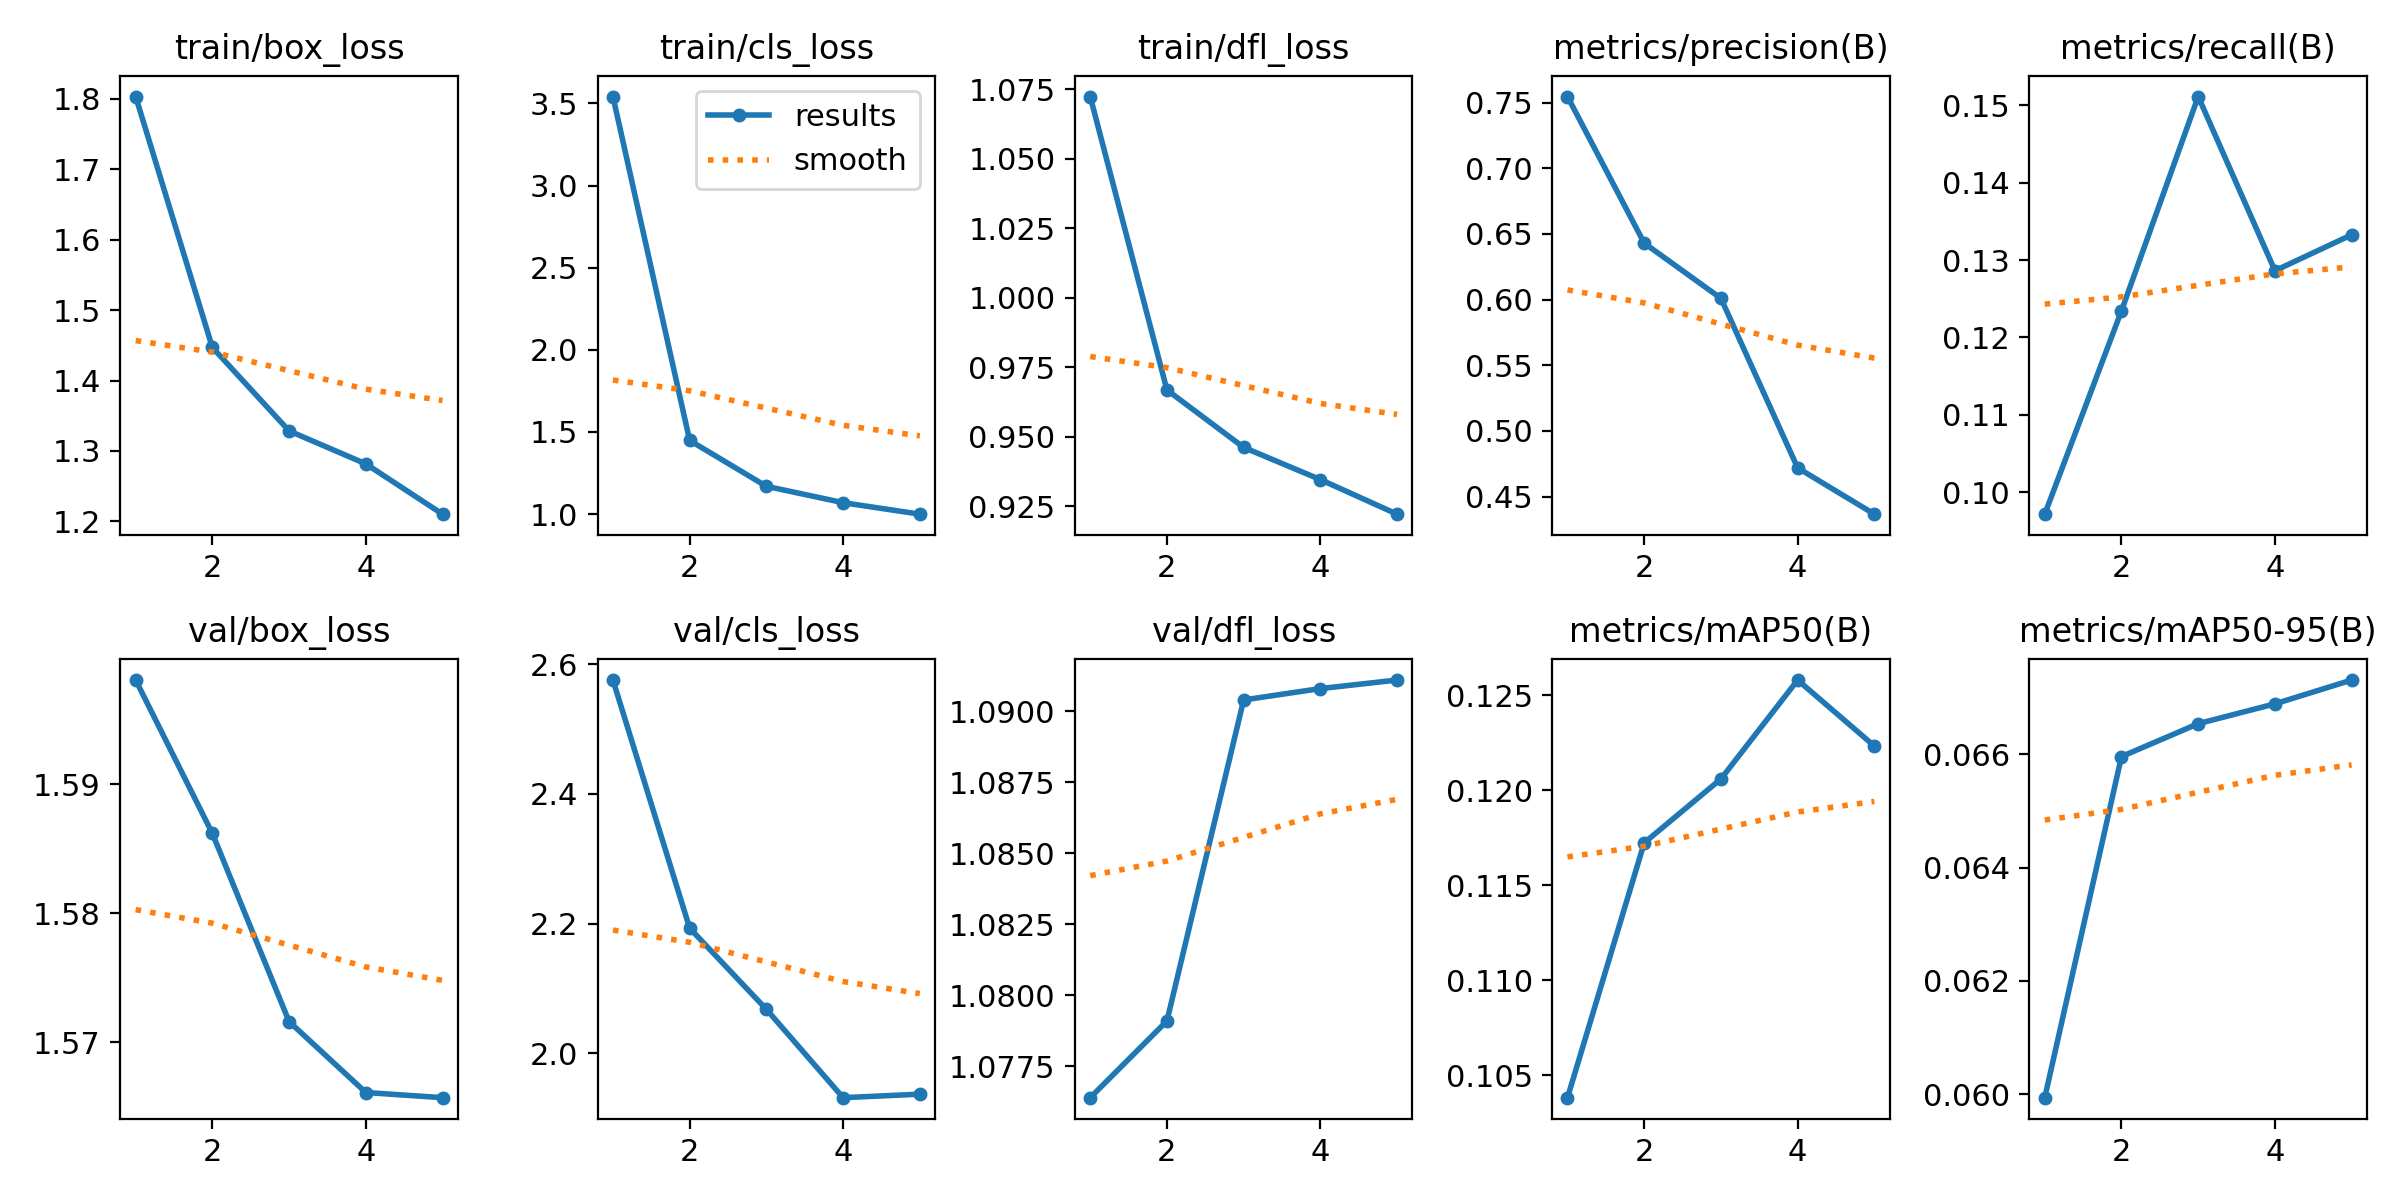

In [18]:
from IPython.display import Image as IPImage

display(IPImage('/content/runs/detect/train2/results.png'))


# YOLOv8 Training Results Analysis

The training results for the YOLOv8 model show promising performance across various metrics over the first few epochs. Below is a summary of the key observations:

## Key Metrics

- **Training Box Loss**: Decreased from **1.8031** to **1.2103** over 5 epochs, indicating improved bounding box predictions.
- **Training Classification Loss**: Reduced from **3.54190** to **0.99976**, suggesting that the model is becoming better at classifying objects.
- **Training DFL Loss**: Showed a decline from **1.07230** to **0.92206**, indicating better distribution function learning.

## Validation Metrics

- **Validation Box Loss**: Remained relatively stable, starting at **1.5981** and ending at **1.9367**. This suggests that while the model is improving on training data, there may be some overfitting, and further tuning might be necessary.
- **Precision and Recall**:
  - Precision (B) decreased from **0.75467** to **0.43662**.
  - Recall (B) increased slightly from **0.09716** to **0.13327**. These metrics indicate that while the model is becoming more sensitive to positive instances, it may also be struggling to maintain high precision.
  
- **Mean Average Precision (mAP)**:
  - mAP50 increased from **0.10383** to **0.12232**, suggesting improved overall detection performance.
  - mAP50-95 remained lower, indicating potential room for improvement, especially across varying IoU thresholds.

## Conclusion

Overall, the YOLOv8 model is demonstrating good initial results, showing improvements in loss metrics and detection capabilities. However, the validation performance suggests that the model may benefit from additional training and more compute power. Increased compute resources could allow for a more extensive search of hyperparameters, larger batch sizes, and potentially more complex architectures, leading to further enhancements in precision, recall, and mAP scores.




# Prediction using pretrained model vs trained fine tuned model


## Loading models and predicting on test images


In [5]:

# Load a pretrained YOLOv8n model
model_ut = YOLO('/content/yolov8n.pt')


100%|██████████| 6.25M/6.25M [00:00<00:00, 103MB/s]


In [20]:

# Load a trained YOLOv8n model
model_t = YOLO('/content/drive/MyDrive/Thermal/YOLOv8 model/train2/weights/best.pt')


### Predicting with pretrained model


In [10]:
# Test the model on a single image
results = model_ut.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_1_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_1_ut.jpg: 512x640 5 persons, 1 car, 1 truck, 1 traffic light, 302.6ms
Speed: 5.8ms preprocess, 302.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


In [11]:
# Test the model on a single image
results = model_ut.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_2_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_2_ut.jpg: 512x640 1 person, 7 cars, 186.9ms
Speed: 3.7ms preprocess, 186.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


In [12]:
# Test the model on a single image
results = model_ut.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_3_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_4_ut.jpg: 512x640 6 persons, 2 cars, 169.9ms
Speed: 2.1ms preprocess, 169.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


In [36]:
# Test the model on a single image
results = model_ut.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_4_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_4_ut.jpg: 512x640 5 persons, 2 cars, 49.4ms
Speed: 1.9ms preprocess, 49.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


In [15]:
results = model_ut.predict(source='/content/drive/MyDrive/Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg: 512x640 1 person, 2 cars, 252.9ms
Speed: 2.1ms preprocess, 252.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


### Predecting with trained fine tuned model


In [21]:
# Test the model on a single image
results = model_t.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_1_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_1_ut.jpg: 512x640 5 persons, 3 cars, 402.8ms
Speed: 15.1ms preprocess, 402.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


In [22]:
# Test the model on a single image
results = model_t.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_2_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_2_ut.jpg: 512x640 2 persons, 8 cars, 197.9ms
Speed: 3.8ms preprocess, 197.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


In [23]:
# Test the model on a single image
results = model_t.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_3_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_3_ut.jpg: 512x640 6 cars, 192.5ms
Speed: 3.9ms preprocess, 192.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


In [24]:
# Test the model on a single image
results = model_t.predict(source='/content/drive/MyDrive/Thermal/test/test_ut/img_4_ut.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/test/test_ut/img_4_ut.jpg: 512x640 5 persons, 2 cars, 192.4ms
Speed: 4.1ms preprocess, 192.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


In [25]:
results = model_t.predict(source='/content/drive/MyDrive/Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg', save=True, conf=0.25)



image 1/1 /content/drive/MyDrive/Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg: 512x640 2 persons, 5 cars, 415.7ms
Speed: 5.4ms preprocess, 415.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict3


# Images with default pretrained model

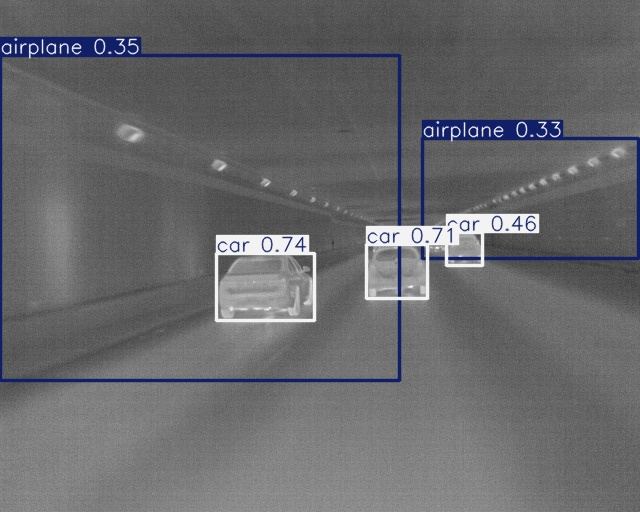

In [9]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict/img_3_ut.jpg'
img = Image.open(result_image_path)
display(img)


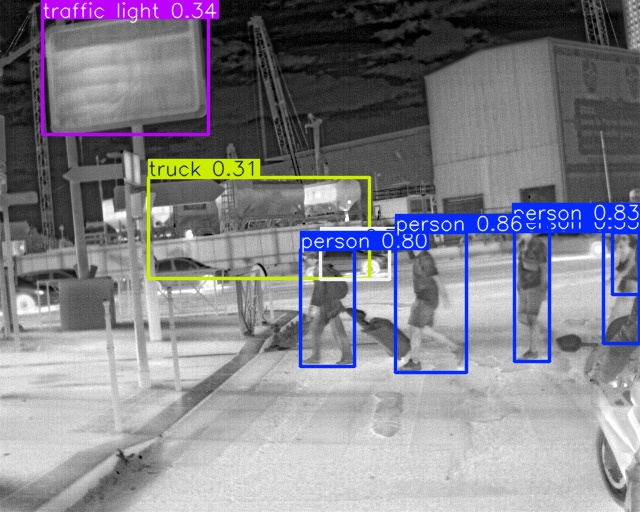

In [16]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict/img_1_ut.jpg'
img = Image.open(result_image_path)
display(img)


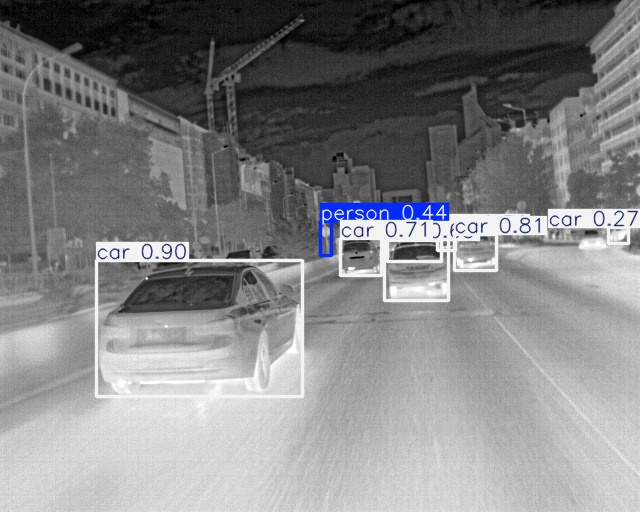

In [17]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict/img_2_ut.jpg'
img = Image.open(result_image_path)
display(img)


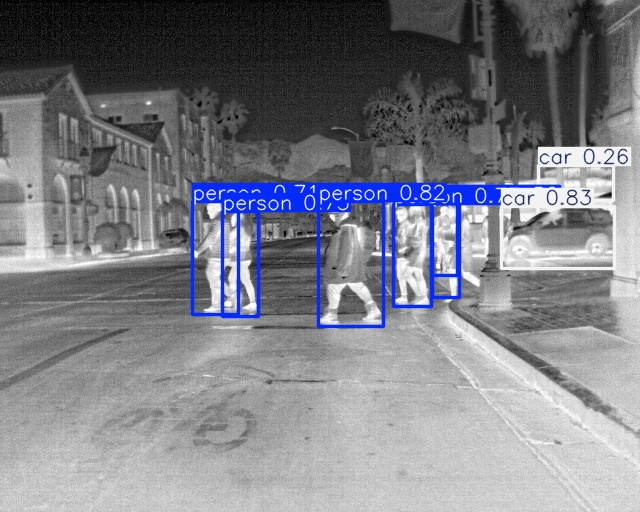

In [18]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict/img_4_ut.jpg'
img = Image.open(result_image_path)
display(img)


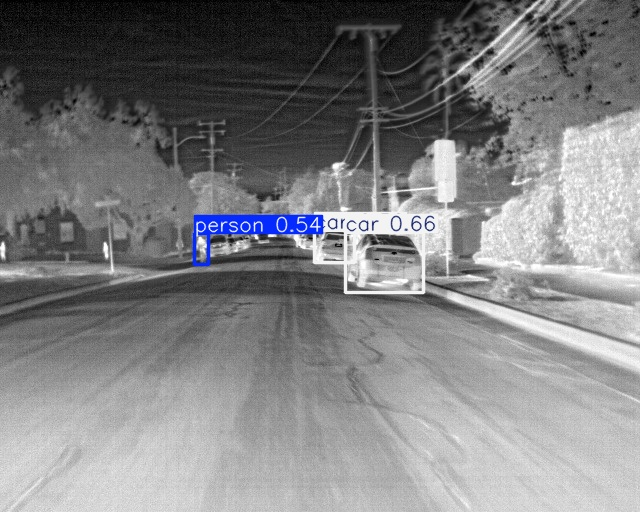

In [19]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg'  # Adjust the path if needed
img = Image.open(result_image_path)
display(img)


# Images with trained fine tuned model

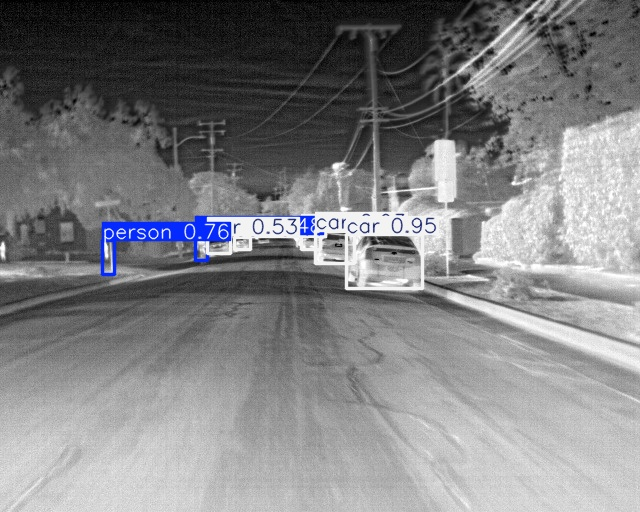

In [26]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict3/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg'
img = Image.open(result_image_path)
display(img)


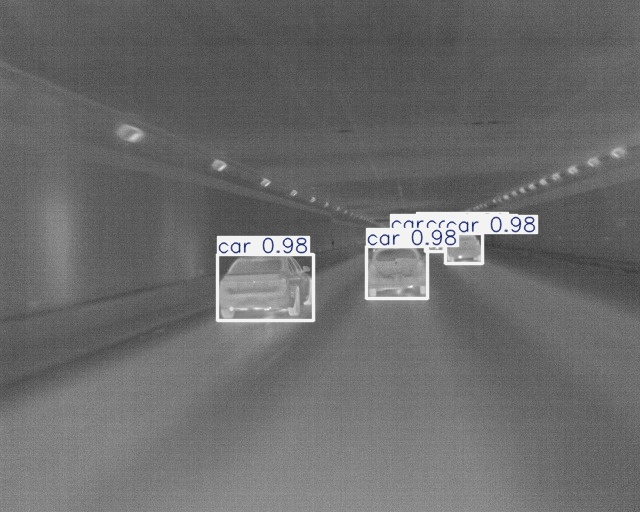

In [27]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict3/img_3_ut.jpg'
img = Image.open(result_image_path)
display(img)


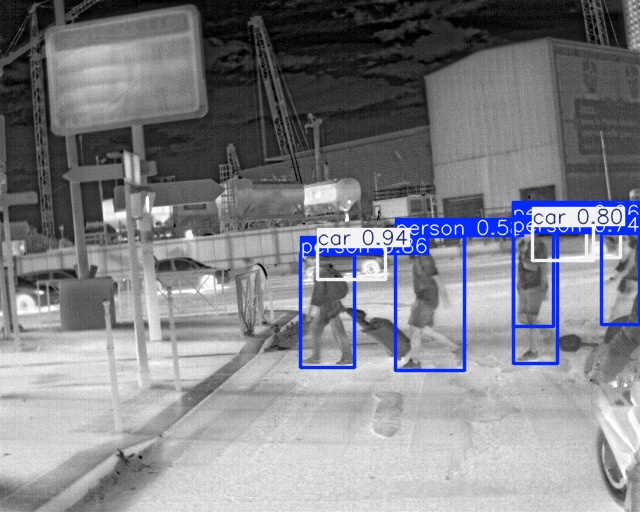

In [28]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict3/img_1_ut.jpg'
img = Image.open(result_image_path)
display(img)


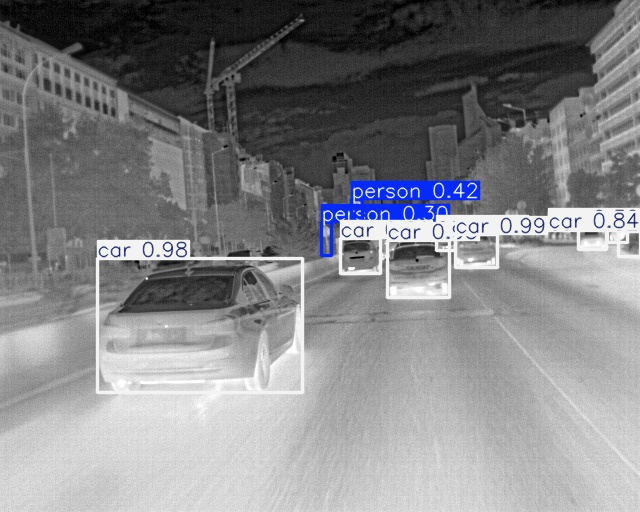

In [29]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict3/img_2_ut.jpg'
img = Image.open(result_image_path)
display(img)


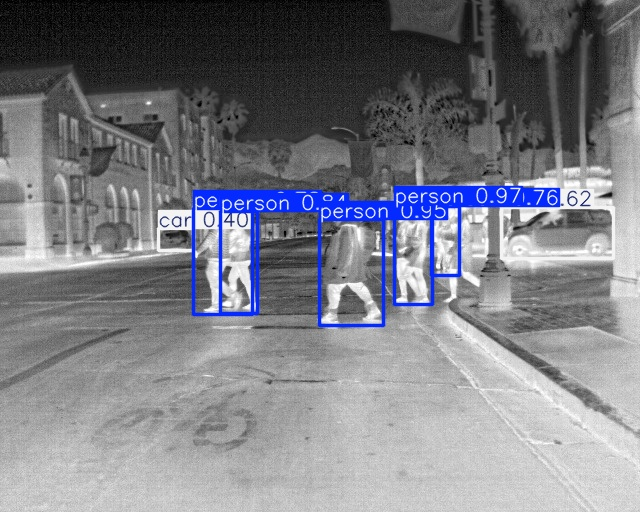

In [30]:
from PIL import Image
from IPython.display import display

# Open and display the result image
result_image_path = '/content/runs/detect/predict3/img_4_ut.jpg'
img = Image.open(result_image_path)
display(img)


# Conclusion
The results demonstrate that the fine-tuned YOLOv8 model significantly outperforms the pre-trained model in object detection accuracy for thermal images. The improved predictions highlight the effectiveness of training on a custom dataset. With additional training and optimization, we can expect the model to achieve even greater performance, making it well-suited for real-world applications in thermal imaging.